# Taxon definition and lineage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import toytree
import toyplot
import scipy.stats as sc

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from adascape.base import IR12SpeciationModel, DD03SpeciationModel
from adascape.fastscape_ext import FastscapeElevationTrait
import pdb

## Functions to compute and visualize speciation model

In [2]:
def run_model(trait_comp=False, num_gen=100, pop_size = 10, dt=1,
             sigma_env_trait=0.3, mut_prob=1.0, sigma_mut=0.05, sigma_mov=5,
             random_seed=1234, distance_value=0.1, distance_metric='centroid',
              taxon_def='spec_clus',always_direct_parent=True):
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(0)
    environment = X + r.rand(*Y.shape)
    trait_01_elev = FastscapeElevationTrait(topo_elevation=environment,
                                        init_trait_min=0.5,
                                        init_trait_max=0.5,
                                        lin_slope=0.95, 
                                        norm_min=environment.min(), 
                                        norm_max=environment.max(), 
                                        random_seed=1234)
    trait_01_elev.initialize()
    init_trait_funcs =  {
    'trait_1': trait_01_elev.init_trait_func,
    }
    opt_trait_funcs = {
    'trait_1': trait_01_elev.opt_trait_func
    }
    
    if trait_comp:
        model = DD03SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, pop_size,
                                    car_cap_max=250, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, sigma_comp_trait=sigma_env_trait, 
                                    sigma_comp_dist=sigma_env_trait, random_seed=random_seed, 
                                    distance_metric=distance_metric, distance_value=distance_value, 
                                    taxon_def=taxon_def, always_direct_parent=always_direct_parent)
    else:
        model = IR12SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, pop_size, 
                                    nb_radius=50, car_cap=25, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, random_seed=random_seed, 
                                    distance_value=distance_value, distance_metric=distance_metric, 
                                    taxon_def=taxon_def, always_direct_parent=always_direct_parent)

    model.initialize()
    dfs = []
    for step in range(num_gen):
        model.evaluate_fitness(dt)
        dfs.append(model.to_dataframe())
        model.update_individuals(dt)
    return pd.concat(dfs).reset_index(drop=True), environment, X

In [3]:
def plot_sol(dtf, elevation, X):
    num_gen = dtf.step.unique().size
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(dtf.groupby('step').size())
    h,xedge,yedge,_=axs1[1,0].hist2d(x=dtf['step'], y=dtf['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(elevation)
    axs1[0, 1].scatter(dtf['x'].loc[dtf['step']==max(dtf['step'])],
                       dtf['y'].loc[dtf['step']==max(dtf['step'])],
                       c=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=dtf['x'].loc[dtf['step']==max(dtf['step'])],
                                     y=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')

In [4]:
def toytree_plot(tree, ind_dtf):
    """
    Plot of phylogenetic tree using library toytree and following the cookbook example 
    https://toytree.readthedocs.io/en/latest/
    
    Parameters
    ----------
    tree : class 'dendropy.tree'
        Phylogenetic tree as class dendropy.tree
    ind_dtf : class 'pandas.DataFrame'
        Speciation model output with data for all individuals
        
    """
    ttree = toytree.tree(tree.as_string(schema='newick'))
    # generate a distribution between 0 and 1 for each tip in the tree
    points = np.linspace(0, 1, 50)
    dists = {}
    for tip in ttree.get_tip_labels():
        trait_values = ind_dtf[ind_dtf.taxon_id==int(tip)].trait_0.values
        if trait_values.size > 1:
            kernel = sc.gaussian_kde(trait_values)                                 
            dists[tip] = kernel(points)
        else:
            dists[tip] = None
    # set up canvas for two panel plot
    canvas = toyplot.Canvas(width=300, height=400)

    # add tree to canvas
    ax0 = canvas.cartesian(bounds=(50, 180, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)
    ttree.draw(axes=ax0, tip_labels=False)
    ax0.show = False

    # add histograms to canvas
    ax1 = canvas.cartesian(bounds=(200, 275, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)

    # iterate from top to bottom (ntips to 0)
    for tip in range(ttree.ntips)[::-1]:

        # select a color for hist
        color = toytree.colors[int((tip) / 10)]

        # get tip name and get hist from dict
        tipname = ttree.get_tip_labels()[tip]
        probs = dists[tipname]
        
        if probs is not None:
            
            # fill histogram with slightly overlapping histograms
            ax1.fill(
                points, probs / probs.max() * 1.25,
                baseline=[tip] * len(points),
                style={"fill": color, "stroke": "white", "stroke-width": 0.5},
                title=tipname,
            )
            # add horizontal line at base
            ax1.hlines(tip, opacity=0.5, color="grey", style={"stroke-width": 0.5})

    # hide y axis, show x
    ax1.y.show = False
    ax1.x.label.text = "Trait value"
    ax1.x.ticks.show = True

## Phylogeny for the speciation model without trait-mediated competition

In [5]:
ind_dtf1, elevation1, X1 = run_model(trait_comp=False)

/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [6]:
ind_dtf1

,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,trait_0
0,0,0.0,0.0,244.174942,110.251531,1,0,8,0.321987,0.500000
1,0,0.0,0.0,95.048934,152.467702,1,0,8,0.932487,0.500000
2,0,0.0,0.0,230.811558,215.905324,1,0,10,0.405734,0.500000
3,0,0.0,0.0,65.423106,215.939418,1,0,5,0.751070,0.500000
4,0,0.0,0.0,79.774265,168.720328,1,0,5,0.853670,0.500000
...,...,...,...,...,...,...,...,...,...,...
22265,99,99.0,0.0,157.545379,47.339532,2553,2503,1,0.992118,0.662593
22266,99,99.0,0.0,179.181266,27.824310,2556,2506,1,0.962680,0.621488
22267,99,99.0,0.0,178.984264,116.579489,2542,2492,1,0.716535,0.949514
22268,99,99.0,0.0,243.683493,42.582969,2558,2508,1,0.918769,0.828686


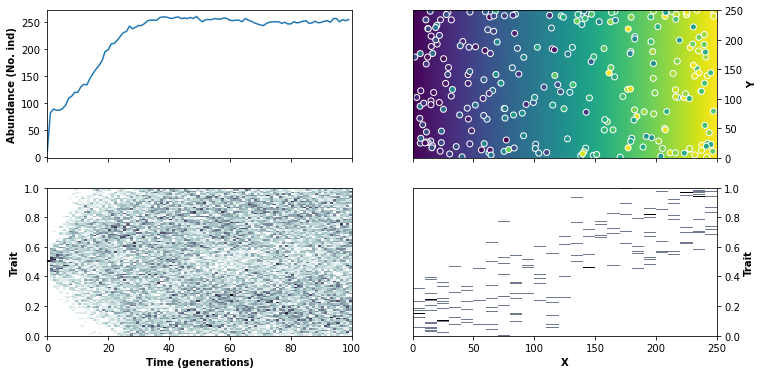

In [7]:
plot_sol(ind_dtf1, elevation1, X1)

In [8]:
taxon_lineage1 = ind_dtf1.ptree.extract_taxon_summary()
taxon_lineage1

,time,taxon_id,ancestor_id,trait_0,abundance,node_type
0,0.0,1,0,0.500000,10,root
1,1.0,2,1,0.497056,81,node
2,2.0,3,2,0.497222,88,node
3,3.0,4,3,0.494617,86,node
4,4.0,5,4,0.509961,86,node
...,...,...,...,...,...,...
2497,99.0,2554,2504,0.723075,4,leaf
2498,99.0,2555,2505,0.699582,4,leaf
2499,99.0,2556,2506,0.751013,4,leaf
2500,99.0,2557,2507,0.778593,9,leaf


In [ ]:
tree1 = ind_dtf1.ptree.to_dendropy_tree()

In [ ]:
tree1.print_plot()

In [ ]:
toytree_plot(tree1, ind_dtf1)

## Tree summary statistics 

Phylogenetic diversity (PD)

In [ ]:
sum(tree1.calc_node_root_distances())

In [ ]:
pdm1=tree1.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [ ]:
pdm1.mean_pairwise_distance()

Mean neighbor taxon distance (MNTD)

In [ ]:
pdm1.mean_nearest_taxon_distance()

Lineages through time (LTT)

In [ ]:
time_steps1 = np.linspace(0, tree1.max_distance_from_root(), 50)
ltt1=[tree1.num_lineages_at(t) for t in time_steps1]
plt.plot(time_steps1, ltt1)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')

## Phylogeny for the speciation model with trait-mediated competition

In [ ]:
ind_dtf2, elevation2, X2 = run_model(trait_comp=True)

In [ ]:
ind_dtf2

In [ ]:
plot_sol(ind_dtf2, elevation2, X2)

In [ ]:
taxon_lineage2 = ind_dtf2.ptree.extract_taxon_summary()
taxon_lineage2

In [ ]:
tree2 = ind_dtf2.ptree.to_dendropy_tree()

In [ ]:
tree2.print_plot()

In [ ]:
toytree_plot(tree2, ind_dtf2)

## Tree summary statistics 

Phylogenetic diversity (PD)

In [ ]:
sum(tree2.calc_node_root_distances())

In [ ]:
pdm2=tree2.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [ ]:
pdm2.mean_pairwise_distance()

Mean neighbor taxon distance (MNTD)

In [ ]:
pdm2.mean_nearest_taxon_distance()

Lineages through time (LTT)

In [ ]:
time_steps2 = np.linspace(0, tree2.max_distance_from_root(), 50)
ltt2 = [tree2.num_lineages_at(t) for t in time_steps2]
plt.plot(time_steps2, ltt2)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')